In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata =  sc.datasets.pbmc3k_processed()

In [3]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [4]:
import torch

In [5]:
import sys
sys.path.append("../src/")

In [6]:
%load_ext autoreload
%autoreload 2

import scdeepaa

In [7]:
import torch
torch.cuda.is_available()

True

In [8]:
input_matrix, norm_factor, distribution_type = scdeepaa.get_input_params_adata(adata)

In [9]:
res = scdeepaa.fit_deepAA(
    [adata.X],
    [np.ones(adata.X.shape[0])],
    ["G"],
    hidden_dims_dec_common = [256,256],
    hidden_dims_dec_last = [512],
    hidden_dims_enc_ind = [512],
    hidden_dims_enc_common = [256,256],
    hidden_dims_enc_pre_Z = [128, 64],
    lr = 0.01,
    gamma_lr = 0.01,
    steps = 1000,
    narchetypes = 5,
    fix_Z = False)


ELBO: 176193075.99463  : 100%|██████████| 1000/1000 [00:14<00:00, 67.74it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


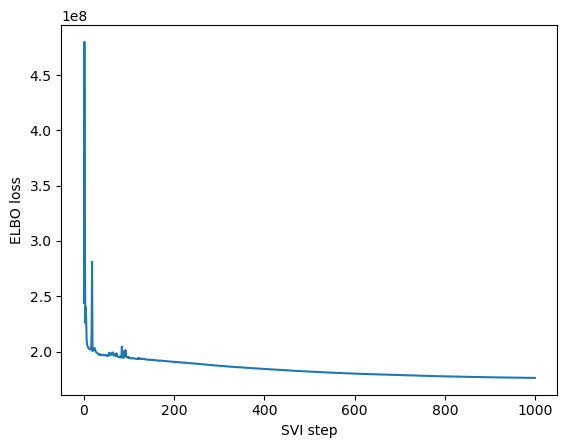

In [10]:
scdeepaa.plot_ELBO(res)

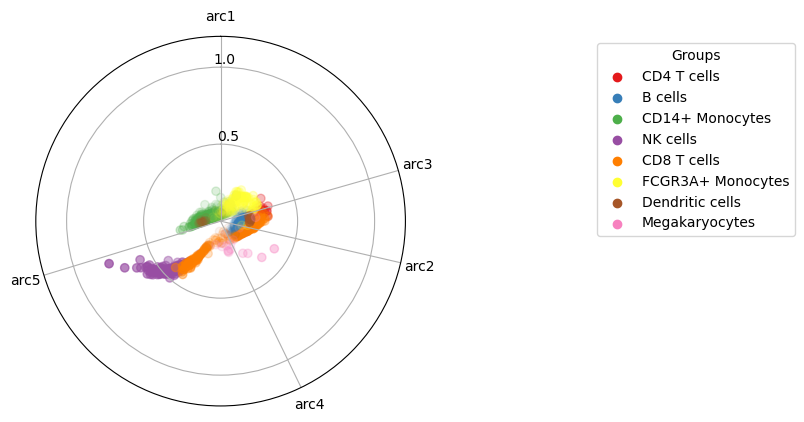

In [11]:
scdeepaa.plot_archetypes_simplex(res, color_by = adata.obs["louvain"], cmap = "Set1")

In [12]:
col_names = [ "arc" + str(i+1) for i in range(res["inferred_quantities"]["A"].shape[1])]

Z_arc = pd.DataFrame(res["inferred_quantities"]["A"], columns= col_names, index = adata.obs_names )

In [13]:
adata =  sc.datasets.pbmc3k_processed()

In [14]:
adata.obs = pd.concat([adata.obs, Z_arc], axis=1)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


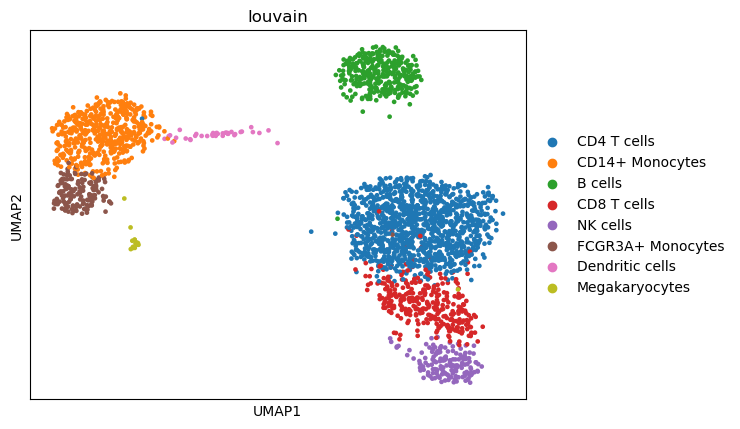

In [15]:
sc.pl.umap(adata, color="louvain")


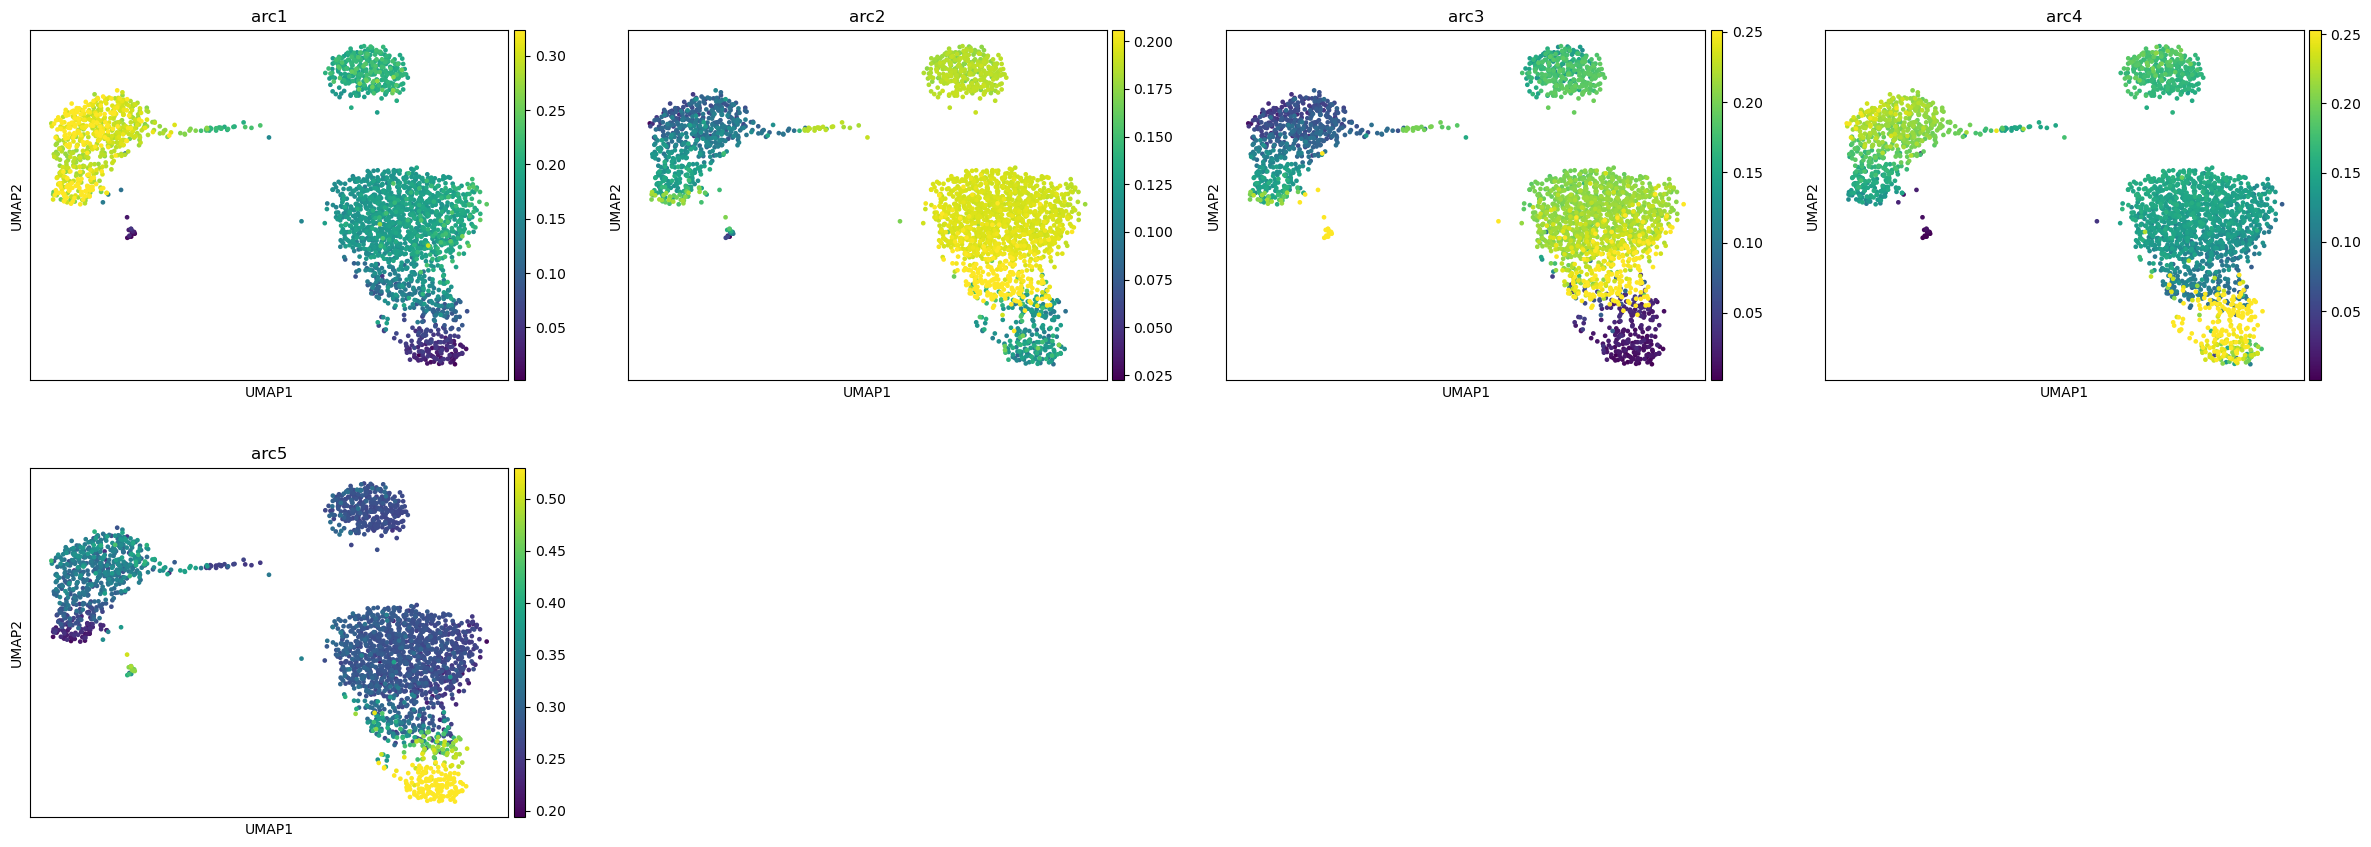

In [16]:
sc.pl.umap(adata, color=col_names, vmax="p95")


In [17]:
adata.obsm["X_aa"] = res["inferred_quantities"]["A"] @ res["inferred_quantities"]["archetypes_inferred"]

In [18]:
sc.pp.neighbors(adata, use_rep = "X_aa",n_neighbors=10)


/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/salvatore.milite/miniconda3/envs/scdee

<Axes: >

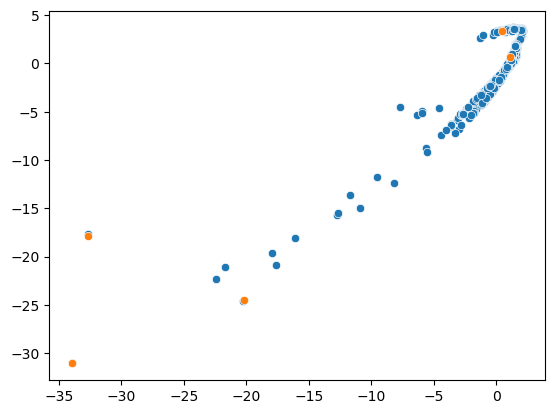

In [19]:
import seaborn as sns

sns.scatterplot(x = res["inferred_quantities"]["Z"][:,0], y = res["inferred_quantities"]["Z"][:,1])

sns.scatterplot(x = res["inferred_quantities"]["archetypes_inferred"][:,0], y = res["inferred_quantities"]["archetypes_inferred"][:,1])

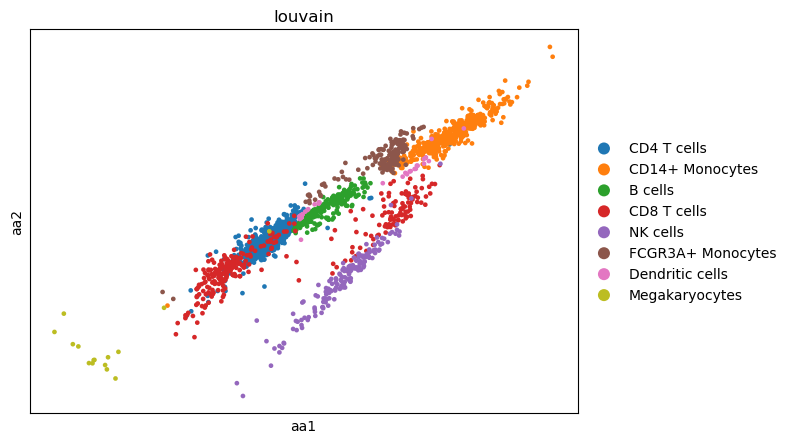

In [20]:
sc.pl.scatter(adata, basis= "aa", color="louvain")

In [21]:
sc.tl.umap(adata)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


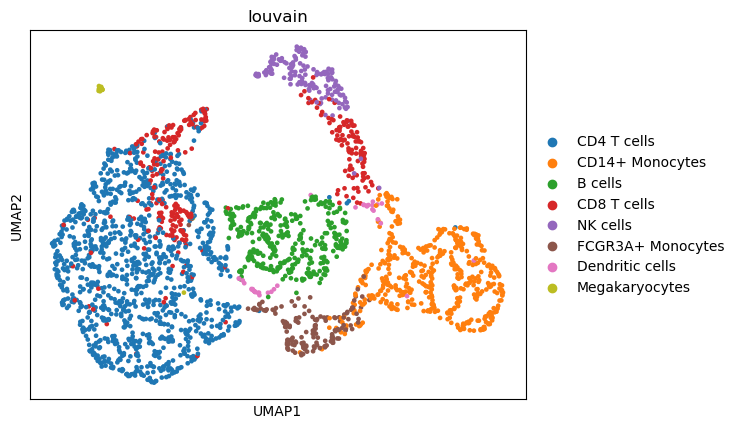

In [22]:
sc.pl.umap(adata, color="louvain")


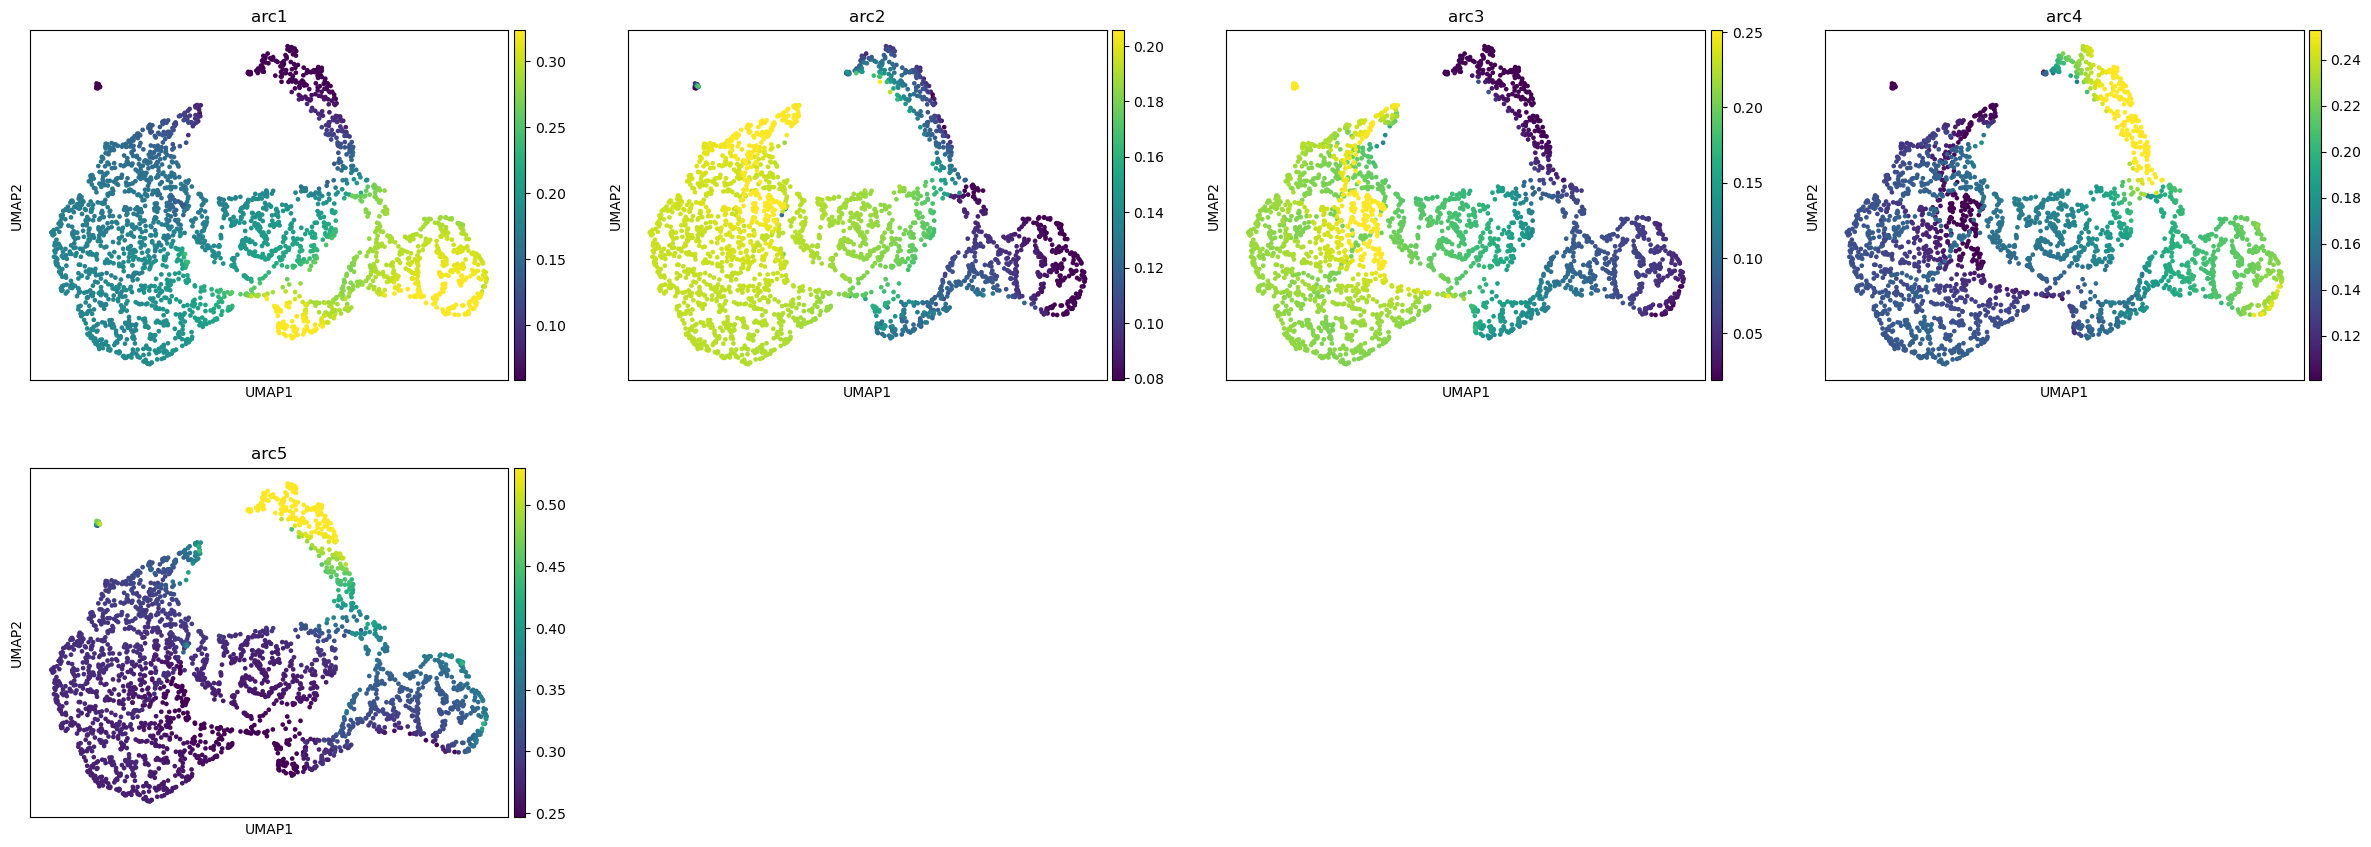

In [23]:
sc.pl.umap(adata, color=col_names, vmax='p95', vmin = "p05")

In [24]:
side_mat = pd.get_dummies(adata.obs["louvain"], prefix='louvain') 
side_mat = side_mat.to_numpy().astype(float)

In [25]:
side_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [26]:
res = scdeepaa.fit_deepAA(
    [adata.X],
    [np.ones(adata.X.shape[0])],
    ["G"],
    side_matrices = [side_mat], 
    input_types_side = ["C"],
    loss_weights_reconstruction = [1e-6],
    loss_weights_side = [1],
    lr = 0.001,
    gamma_lr = 0.01,
    steps = 600,
    narchetypes = 8,
    fix_Z = False
    )

ELBO: -22248.04942  : 100%|██████████| 600/600 [00:13<00:00, 46.04it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


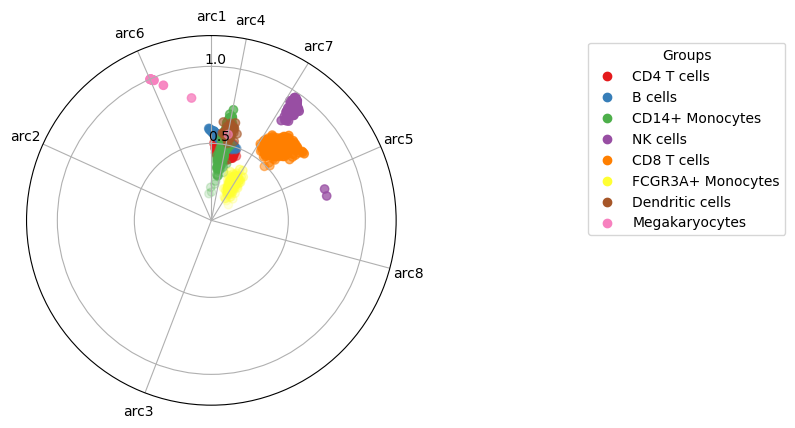

In [27]:
scdeepaa.plot_archetypes_simplex(res, color_by = adata.obs["louvain"], cmap = "Set1")

In [28]:
adata =  sc.datasets.pbmc3k_processed()

In [29]:
col_names = [ "arc" + str(i+1) for i in np.arange(res["hyperparametes"]["narchetypes"])]

In [30]:
Z_arc = pd.DataFrame(res["inferred_quantities"]["A"], columns= col_names, index = adata.obs_names )

In [31]:
adata.obs = pd.concat([adata.obs, Z_arc], axis=1)

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


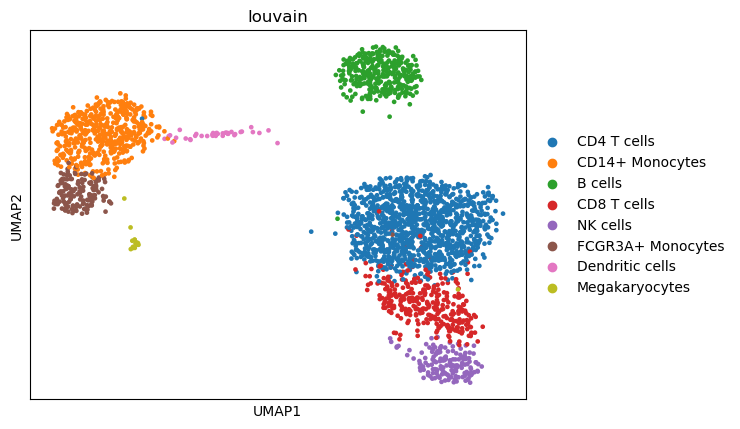

In [32]:
sc.pl.umap(adata, color="louvain")


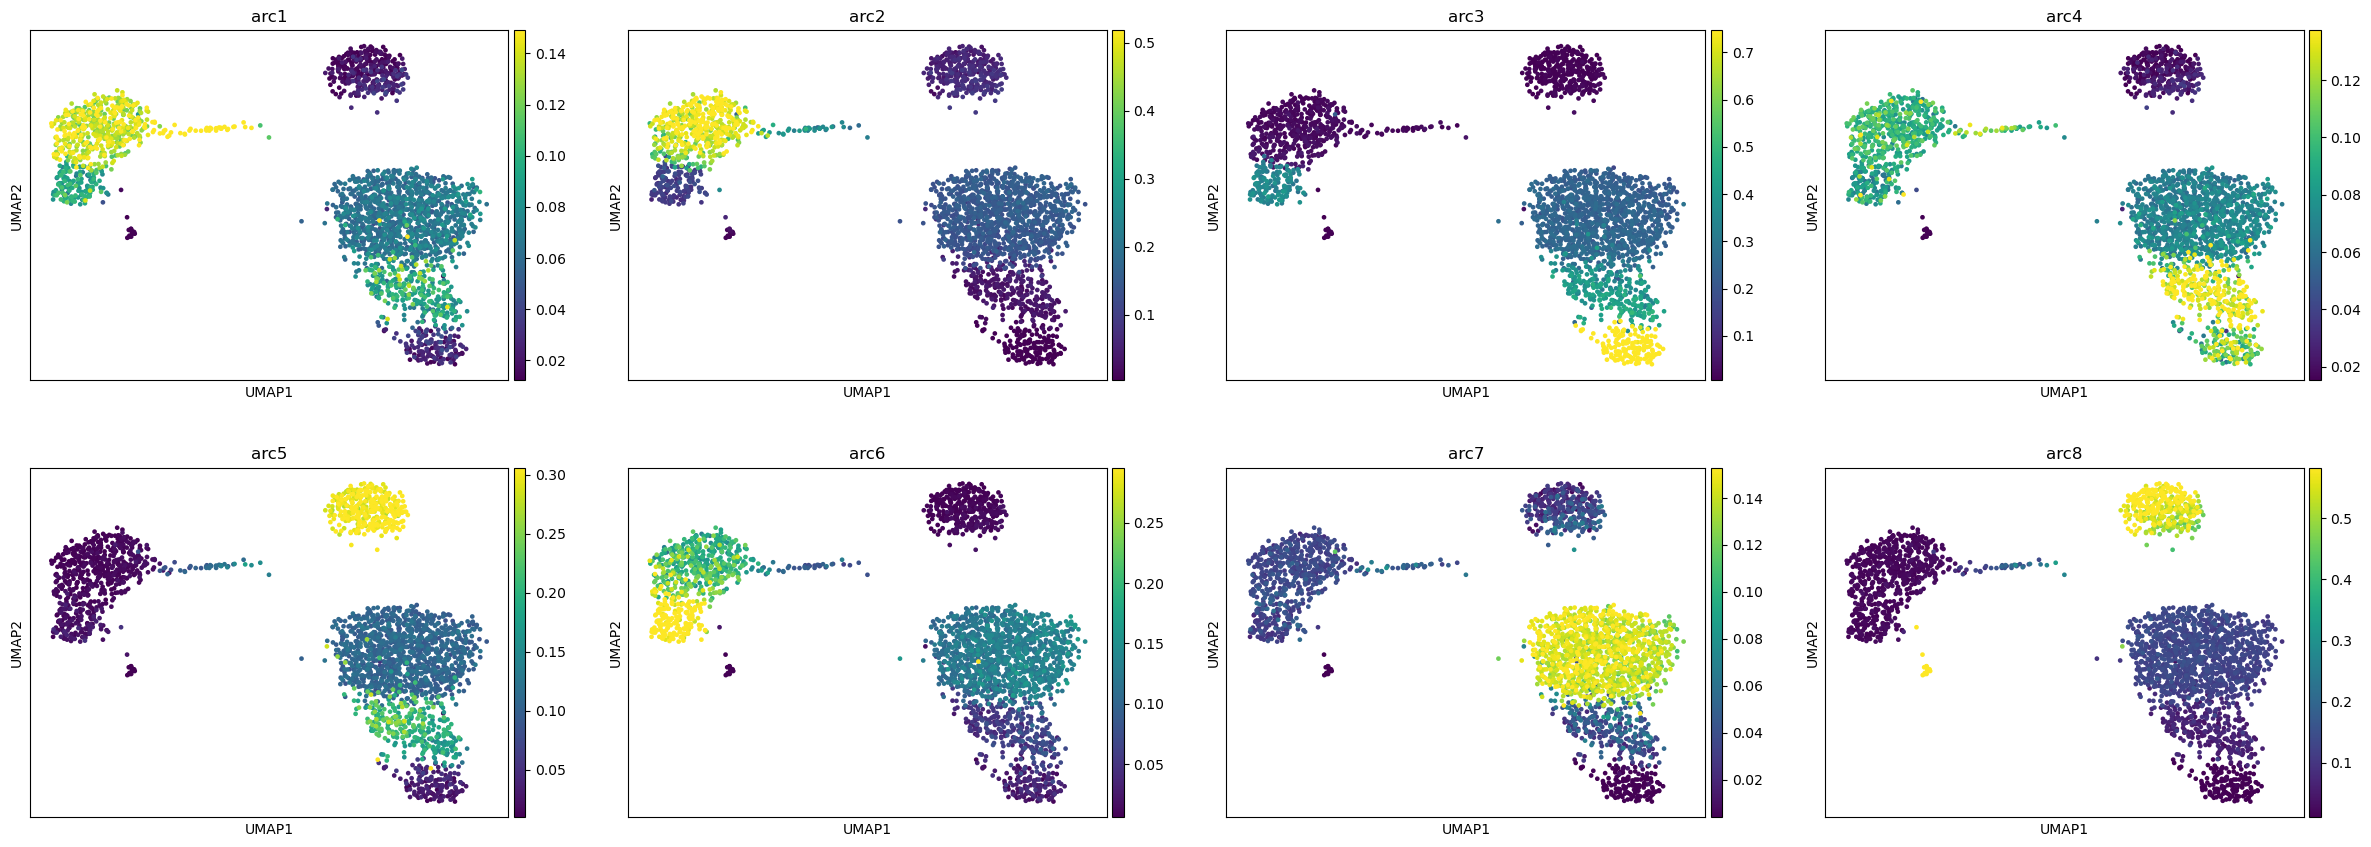

In [33]:
sc.pl.umap(adata, color=col_names, vmax='p95', vmin = "p05")

In [34]:
res["inferred_quantities"]["input_loss"]

array(-227.47482, dtype=float32)

In [35]:
res["inferred_quantities"]["side_loss"]

array(-15978.242, dtype=float32)

In [36]:
adata.obsm["X_aa"] = res["inferred_quantities"]["A"] @ res["inferred_quantities"]["archetypes_inferred"]

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


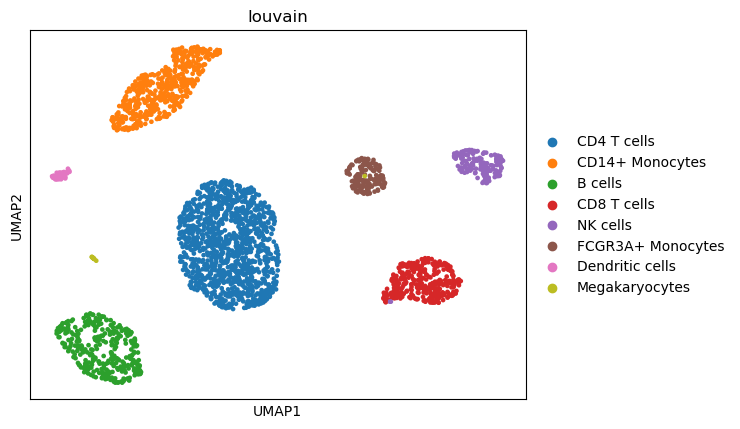

In [37]:
sc.pp.neighbors(adata, use_rep = "X_aa")
sc.tl.paga(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="louvain")


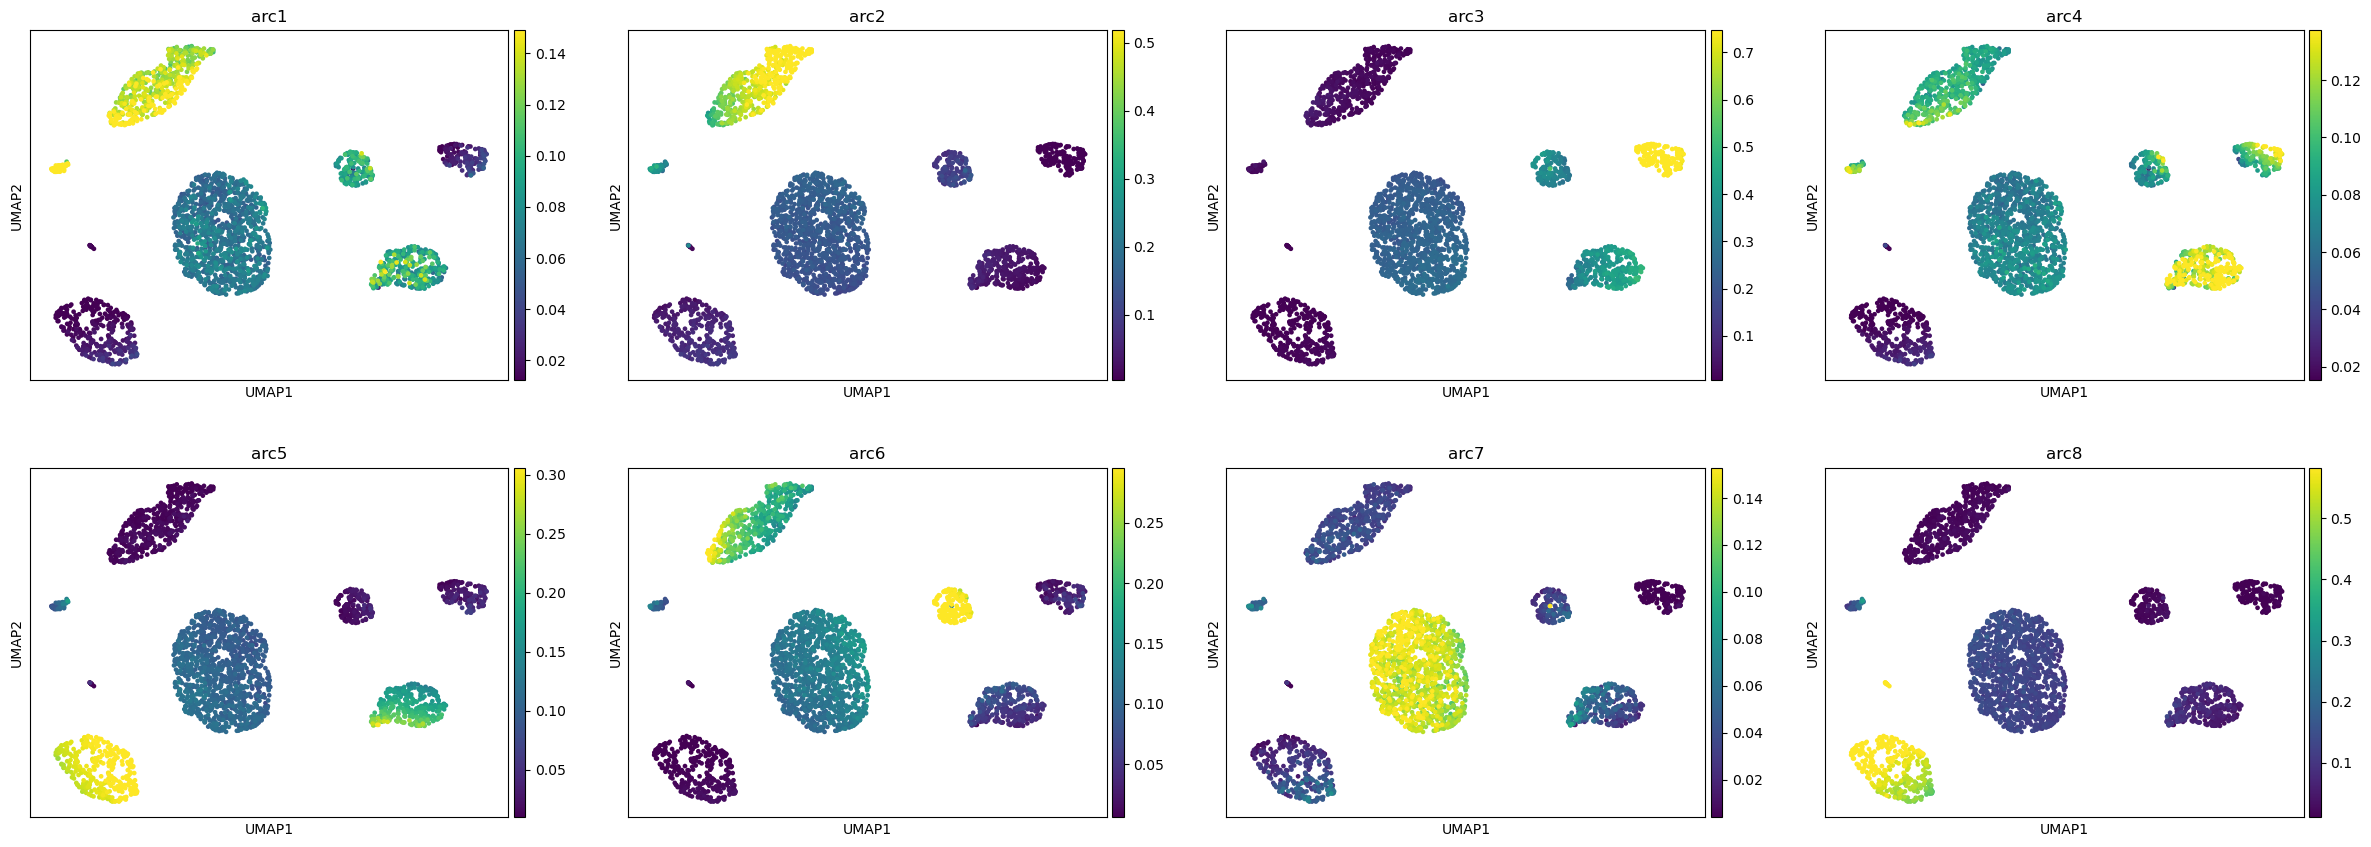

In [38]:
sc.pl.umap(adata, color=col_names, vmax='p95', vmin = "p05")

In [39]:
sc.tl.leiden(adata, resolution=0.05)


/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


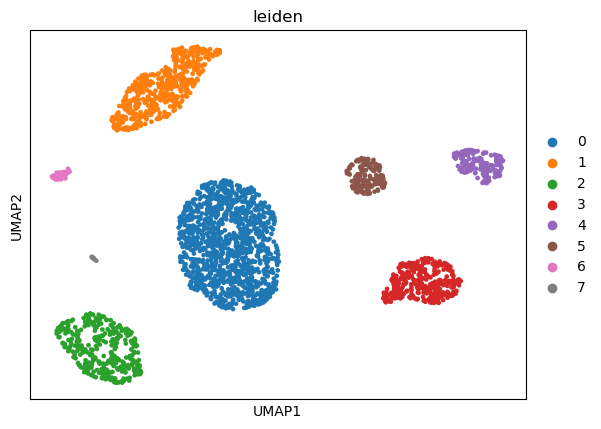

In [40]:
sc.pl.umap(adata, color="leiden")


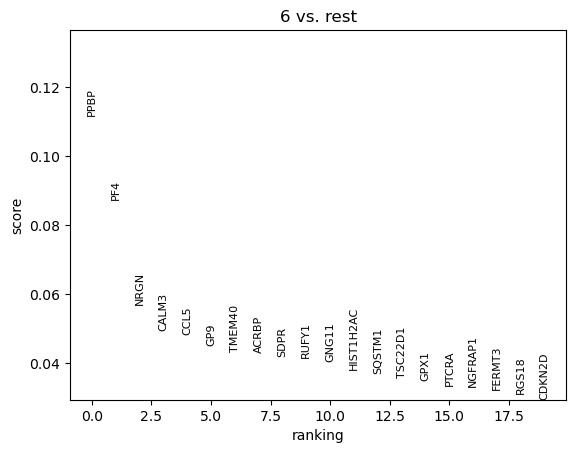

In [41]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg', groups=[6,7])
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

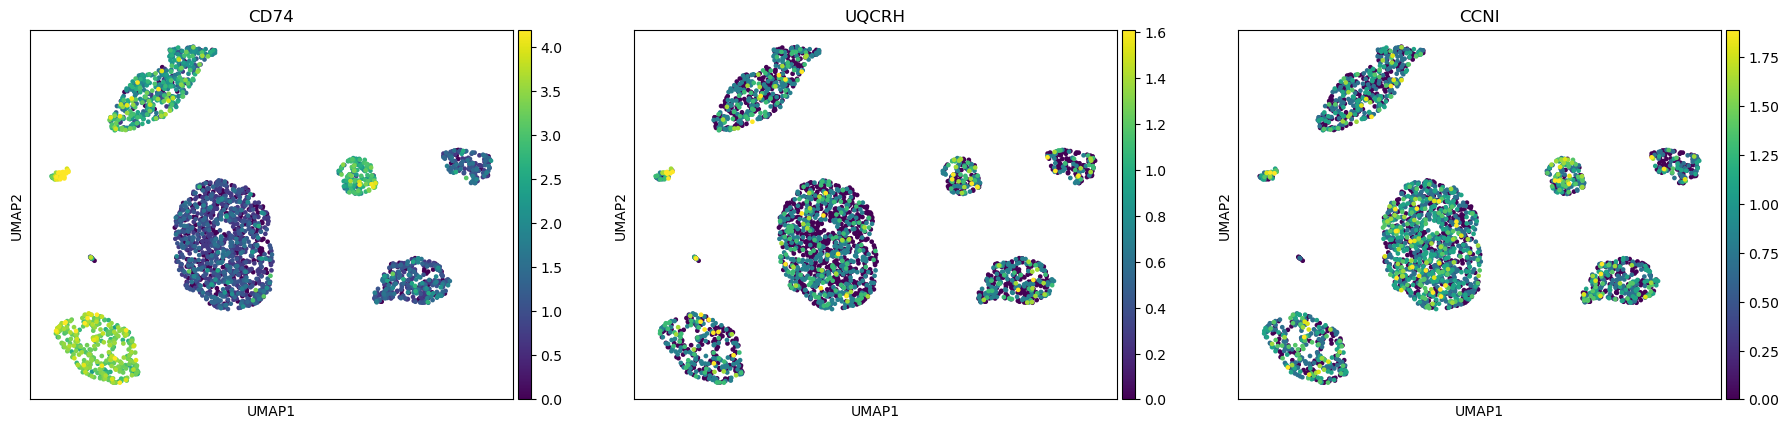

In [42]:
sc.pl.umap(adata, color=["CD74", "UQCRH", "CCNI"], vmax = "p99")
